In [136]:
import pygad as pg
import numpy as np
import random


In [137]:
# set = [random.randint(-1000, 1000) for i in range(100)]
set = [-7, -3, -2, 9000, 5, 8]
T = 0


In [138]:
gene_space = [0, 1]
num_genes = len(set)


In [139]:
def fitness_func(solution, solution_idx):
    for i in solution:
        if i == 1:
            res = np.sum([a*b for a, b in zip(solution, set)])
            return -abs(T-res)
    return -100


In [140]:
fitness_func([0, 1, 1, 0, 1, 1], 0)


-8

In [141]:
sol_per_pop = 100
num_parents_mating = 50
num_generations = 1000
keep_parents = 25
parent_selection_type = "sss"
crossover_type = "single_point"
mutation_type = "random"
mutation_num_genes = 1
stop_criteria = "reach_0"

ga_instance = pg.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_num_genes=mutation_num_genes,
    stop_criteria=stop_criteria
)


(array([0., 1., 1., 0., 1., 0.]), -0.0, 0)


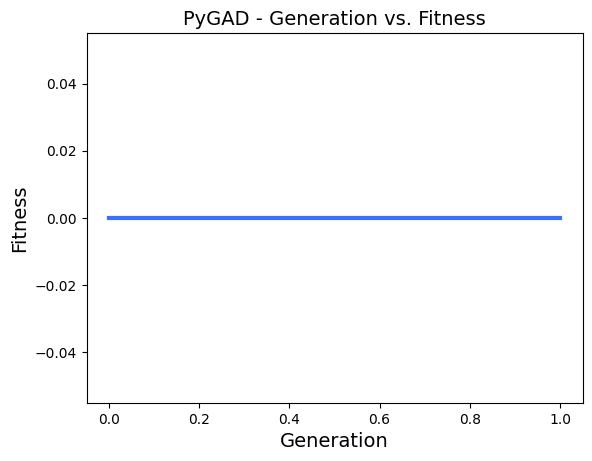

In [142]:
ga_instance.run()

x = ga_instance.best_solution()
print(x)

ga_instance.plot_fitness()
print()


In [143]:
y = []
y2 = []
for i in range(len(x[0])):
    if x[0][i]:
        y2.append(set[i])
        y.append("("+str(set[i])+")")

print(" + ".join(y) + " = " + str(T))

print(np.sum(y2) == T)


(-3) + (-2) + (5) = 0
True


In [144]:
from pyswarms.utils.plotters import plot_cost_history
from pyswarms.discrete.binary import BinaryPSO
import matplotlib.pyplot as plt


In [145]:
def sum_of(y):
    for i in y:
        if i == 1:
            res = np.sum([a*b for a, b in zip(y, set)])
            return abs(T-res)
    return 100


In [146]:
def optimizer_function(x):
    n_particles = x.shape[0]
    j = [sum_of(x[i]) for i in range(n_particles)]
    return np.array(j)


In [147]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 1.2}


In [148]:
optimizer = BinaryPSO(
    n_particles=10, dimensions=len(set), options=options)

cost, pos = optimizer.optimize(optimizer_function, iters=1000, verbose=False)

print("Best endurance: {}".format(cost))
print("Parameters of the best solution: {}".format(pos))


Best endurance: 0.0
Parameters of the best solution: [0 1 1 0 1 0]


In [149]:
print(x[0])
print(pos)


[0. 1. 1. 0. 1. 0.]
[0 1 1 0 1 0]
